In [1]:
from thesispy.experiments.wandb_client import *
from thesispy.definitions import *
from thesispy.plot_utils import *
from thesispy.elastix_wrapper.wrapper import run
from thesispy.elastix_wrapper.parameters import Parameters
from thesispy.experiments.instance import read_controlpoints, read_transform_params
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np

In [2]:
ds = get_runs_as_dataset("synthetic_1_hybrid_sweep")
ds.save()

In [3]:
df = ds.aggregate(["NumberOfASGDIterations", "TauASGD"], ["metric", "dvf_rmse"])
df.replace("None", 0, inplace=True)
df = df.astype({"NumberOfASGDIterations": int, "TauASGD": float})

taus = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
dfs_tau = [df.loc[df.TauASGD == tau] for tau in taus]

/tmp/ipykernel_29953/3806148820.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax = sns.heatmap(df.pivot("NumberOfASGDIterations", "TauASGD", "dvf_rmse"), annot=True, fmt=".2f", cmap="bone_r", ax=axes[1])


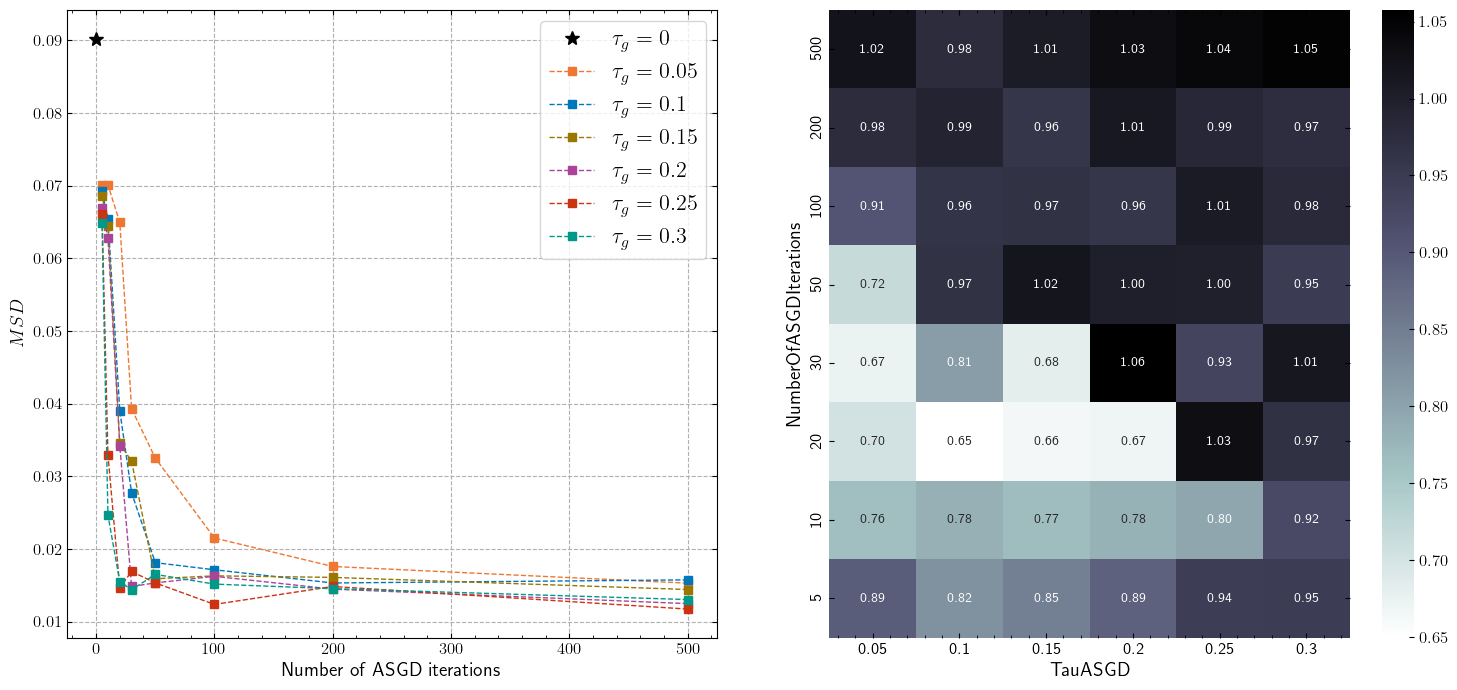

In [4]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, df_tau in enumerate(dfs_tau):
    if i == 0:
        axes[0].plot(df_tau.NumberOfASGDIterations, df_tau["metric"], '*', label=f"$\\tau_g = {taus[i]}$", markersize=10, c="black")
    else:
        axes[0].plot(df_tau.NumberOfASGDIterations, df_tau["metric"], '--s', label=f"$\\tau_g = {taus[i]}$", linewidth=1)

df = df.loc[df.NumberOfASGDIterations > 0]
ax = sns.heatmap(df.pivot("NumberOfASGDIterations", "TauASGD", "dvf_rmse"), annot=True, fmt=".2f", cmap="bone_r", ax=axes[1])
ax.invert_yaxis()

axes[0].legend(prop={'size': 16})
axes[0].set_xlabel("Number of ASGD iterations")
axes[0].set_ylabel("$MSD$")

plt.tight_layout(w_pad=5.0)
plt.savefig("hybrid_sweep.pdf")

2023-01-17 16:46:06,195 - Validation - INFO - Calculating validation metrics:
2023-01-17 16:46:06,202 - Validation - INFO - DVF RMSE: 0.3559339599184027
computing bending energy: 100%|██████████| 13824/13824 [00:01<00:00, 9685.94it/s]
2023-01-17 16:46:07,634 - Validation - INFO - Bending Energy: 0.08665307506583594
2023-01-17 16:46:09,720 - Validation - INFO - Jacobian min,max: 0.4102616974472811, 6.844996595510964
2023-01-17 16:46:09,734 - Validation - INFO - Dice Similarities: Cube: 0.994273394866267, Sphere: 0.927461139896373
2023-01-17 16:46:10,503 - Validation - INFO - Hausdorff Distances: Cube: 0.9276993657903198, Sphere: 0.7344013154291731
2023-01-17 16:46:10,551 - Validation - INFO - Mean Surface Distances: Cube: 0.3989281007851343, Sphere: 0.3075598247012359
2023-01-17 16:46:10,552 - Validation - INFO - TRE: 0.7279556095754287
/home/joasiee/Documents/projects/elastix/experiments/thesispy/experiments/validation.py:399: UserWarning: Tight layout not applied. tight_layout cannot 

TypeError: list indices must be integers or slices, not str

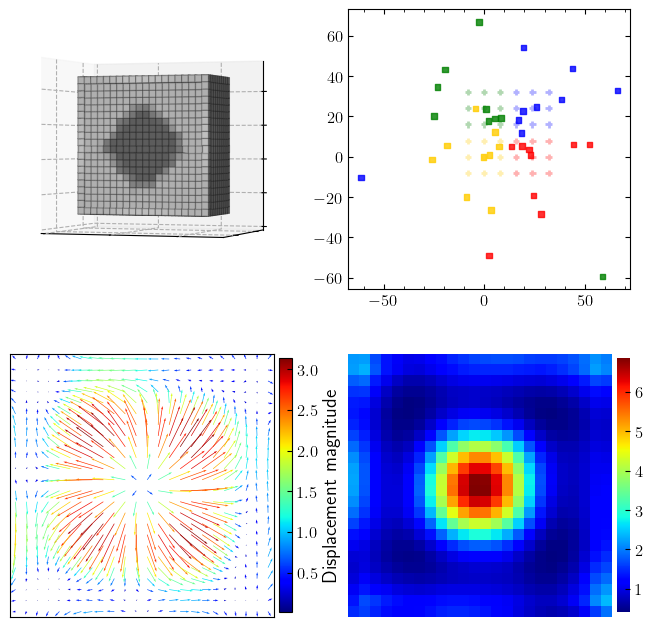

In [19]:
from thesispy.experiments.validation import calc_validation

baseline_runs = []
mesh_sizes = [(3, 3, 3), (4, 4, 4), (5, 5, 5)]

for mesh_size in mesh_sizes:
    runs = get_runs("synthetic_1_fair_comparison", {"config.MeshSize": mesh_size, "config.Optimizer": "GOMEA"})
    baseline_runs.append(runs)

baseline_rmses = []
baseline_tres = []
baseline_bes = []

def get_val_value(val_results, key):
    for val_result in val_results:
        if key in val_result:
            return val_result[key]
    print(f"{key} not found")
    return None

for runs in baseline_runs:
    rmses = []
    tres = []
    bes = []
    for run in runs:
        res = get_run_result("synthetic_1_fair_comparison", run.id)
        val_results = calc_validation(res)
        rmses.append(get_val_value(val_results, "validation/dvf_rmse"))
        tres.append(get_val_value(val_results, "validation/tre"))
        bes.append(get_val_value(val_results, "validation/bending_energy"))
  
    baseline_rmses.append(rmses)
    baseline_tres.append(tres)
    baseline_bes.append(bes)

In [18]:
baseline_runs[0][0].id

'20eqeinu'